https://github.com/muhammadghazyy/skripsi2022/blob/main/RiceLeafDetection.ipynb

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import re
import pickle
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
# function cleaning
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")

**BUNGA**

In [4]:
# get data
dataset_dir = "/content/drive/MyDrive/dataset isna/bunga"

imgs = [] #list image matrix
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    img_files = os.listdir(os.path.join(dataset_dir, folder))
    len_files = len(img_files)
    for i, filename in enumerate(img_files):
        img = cv2.imread(os.path.join(dataset_dir, folder, filename))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grayscale

        h, w = gray.shape
        # print(h)
        # print(w)
        # ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
        ymin, ymax, xmin, xmax = h//2, h*2//3, w//2, w*2//3
        crop = gray[ymin:ymax, xmin:xmax]

        resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5) # resize

        imgs.append(gray)
        labels.append(normalize_label(os.path.splitext(folder)[0]))
        descs.append(normalize_desc(folder, ''))

        print_progress(i, len_files, folder, '', filename)

4
vanda


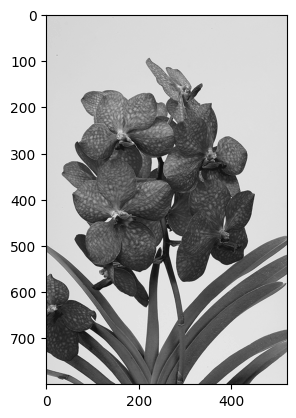

In [5]:
#showing random pic

%matplotlib inline

i = np.random.randint(len(imgs))
print(i)
print(labels[i])
# cv2.imshow('rice',imgs[i])

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# image = cv2.imread(imgs[i])

#Show the image with matplotlib
plt.imshow(imgs[i], cmap = 'gray')
plt.show()

In [6]:
imgs[i].shape

(800, 521)

In [7]:
#calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    glcm = greycomatrix(img, distances=dists, angles=agls, levels=lvl,symmetric=sym, normed=norm)
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]

    feature = []
    for item in glcm_props:
            feature.append(item)
    feature.append(label)

    return feature

In [8]:
properties = ['correlation', 'homogeneity', 'contrast', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [9]:
glcm_df = pd.DataFrame(glcm_all_agls, columns = columns)
glcm_df.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label
0,0.677385,0.637640,0.697524,0.634192,0.056419,0.052030,0.058483,0.052611,2218.668251,2496.176285,2090.861241,2519.755743,0.008124,0.007721,0.008198,0.007840,vanda
1,0.737656,0.660867,0.681158,0.692118,0.072037,0.051924,0.055319,0.058976,2288.716451,2921.313421,2731.474538,2652.153071,0.022180,0.013129,0.012011,0.013255,vanda
2,0.834583,0.827230,0.849354,0.821340,0.114260,0.087867,0.094247,0.086776,686.861648,714.953930,629.338945,739.320401,0.015022,0.013312,0.013793,0.013296,vanda
3,0.571649,0.533925,0.603360,0.536874,0.080125,0.073075,0.078473,0.071742,1598.379532,1733.139452,1462.386735,1722.191868,0.012791,0.012346,0.012902,0.012133,vanda
4,0.848562,0.854617,0.865159,0.852067,0.330926,0.332863,0.337343,0.332625,1706.527720,1638.149393,1517.909458,1666.878704,0.069336,0.069519,0.069910,0.068951,vanda


In [15]:
glcm_df2 = glcm_df.join(pd.get_dummies(glcm_df['label'])).drop('label',axis = 1)

###########################
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(glcm_df['label'])
glcm_df['label_enc'] = le.transform(glcm_df['label'])

In [16]:
glcm_df

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label,label_enc
0,0.677385,0.637640,0.697524,0.634192,0.056419,0.052030,0.058483,0.052611,2218.668251,2496.176285,2090.861241,2519.755743,0.008124,0.007721,0.008198,0.007840,vanda,3
1,0.737656,0.660867,0.681158,0.692118,0.072037,0.051924,0.055319,0.058976,2288.716451,2921.313421,2731.474538,2652.153071,0.022180,0.013129,0.012011,0.013255,vanda,3
2,0.834583,0.827230,0.849354,0.821340,0.114260,0.087867,0.094247,0.086776,686.861648,714.953930,629.338945,739.320401,0.015022,0.013312,0.013793,0.013296,vanda,3
3,0.571649,0.533925,0.603360,0.536874,0.080125,0.073075,0.078473,0.071742,1598.379532,1733.139452,1462.386735,1722.191868,0.012791,0.012346,0.012902,0.012133,vanda,3
4,0.848562,0.854617,0.865159,0.852067,0.330926,0.332863,0.337343,0.332625,1706.527720,1638.149393,1517.909458,1666.878704,0.069336,0.069519,0.069910,0.068951,vanda,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.956755,0.951020,0.958894,0.950477,0.235197,0.223385,0.238383,0.231827,500.431487,567.706601,475.881394,573.993843,0.043067,0.041114,0.043278,0.043132,cattleya,0
96,0.855910,0.847738,0.880570,0.858531,0.070776,0.071781,0.083846,0.069179,1306.681708,1387.157250,1085.104656,1289.045972,0.010247,0.010366,0.010993,0.010313,cattleya,0
97,0.928480,0.915944,0.942145,0.928279,0.255227,0.215512,0.277075,0.210240,350.858790,411.038719,282.426075,350.737721,0.025782,0.022440,0.025755,0.022262,cattleya,0
98,0.956926,0.952953,0.956724,0.952632,0.233837,0.209966,0.225352,0.216193,618.950869,675.939379,622.001281,680.548627,0.029808,0.025954,0.027485,0.026382,cattleya,0


In [17]:
# Shuffling the dataset
glcm_df3 = glcm_df.drop('label',axis=1)

from sklearn.utils import shuffle
shuffled = shuffle(glcm_df3, random_state=1)
shuffled.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label_enc
80,0.950162,0.946302,0.957117,0.947990,0.150968,0.139526,0.151363,0.136739,710.209608,764.635457,611.501857,740.572506,0.013383,0.012909,0.013344,0.012779,0
84,0.932427,0.929065,0.925855,0.914806,0.278376,0.277755,0.282253,0.249971,122.354054,128.797507,134.962733,154.691322,0.026899,0.026894,0.026809,0.025041,0
33,0.867229,0.894278,0.918067,0.858231,0.644897,0.637382,0.650689,0.639669,1062.040215,848.335074,655.508116,1137.587103,0.498360,0.496594,0.500521,0.496803,2
81,0.923297,0.916303,0.924656,0.909694,0.169843,0.158701,0.175505,0.163967,538.389702,586.535564,528.303173,632.919929,0.016280,0.015696,0.016576,0.016059,0
93,0.894317,0.887974,0.913699,0.899567,0.141167,0.135431,0.161768,0.141474,926.009513,983.689309,756.111785,881.874873,0.013721,0.013520,0.015182,0.013981,0


In [18]:
# Train test split 80-20

from sklearn.model_selection import train_test_split

X = shuffled.drop('label_enc',axis=1)
y = shuffled['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV

clf = OneVsRestClassifier(SVC()).fit(X_train,y_train)
clf_lin = OneVsRestClassifier(SVC(kernel = 'linear')).fit(X_train,y_train)
clf_poly = OneVsRestClassifier(SVC(kernel = 'poly')).fit(X_train,y_train)
clf_sig = OneVsRestClassifier(SVC(kernel = 'sigmoid')).fit(X_train,y_train)

clf2 = OneVsRestClassifier(RandomForestClassifier()).fit(X_train,y_train)
clf3 = OneVsRestClassifier(DecisionTreeClassifier()).fit(X_train,y_train)
clf4 = OneVsRestClassifier(KNeighborsClassifier()).fit(X_train,y_train)
clf5 = OneVsRestClassifier(LGBMClassifier()).fit(X_train,y_train)
clf6 = OneVsRestClassifier(xgb.XGBClassifier()).fit(X_train,y_train)
clf7 = OneVsRestClassifier(LogisticRegression()).fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 17, number of negative: 63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212500 -> initscore=-1.309921
[LightGBM] [Info] Start training from score -1.309921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [20]:
# Train pred

y_pred = clf.predict(X_train)
y_pred_lin = clf_lin.predict(X_train)
y_pred_poly = clf_poly.predict(X_train)
y_pred_sig = clf_sig.predict(X_train)

y_pred2 = clf2.predict(X_train)
y_pred3 = clf3.predict(X_train)
y_pred4 = clf4.predict(X_train)
y_pred5 = clf5.predict(X_train)
y_pred6 = clf6.predict(X_train)
y_pred7 = clf7.predict(X_train)

In [21]:
print('Train Score')
print(f"SVM - RBF      :{round(accuracy_score(y_train,y_pred),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_train,y_pred_lin),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_train,y_pred_poly),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_train,y_pred_sig),3)*100}%")

print(f"Random Forest  :{round(accuracy_score(y_train,y_pred2),3)*100}%")
print(f"Decision Tree  :{round(accuracy_score(y_train,y_pred3),3)*100}%")
print(f"KNN            :{round(accuracy_score(y_train,y_pred4),3)*100}%")
print(f"XGB            :{round(accuracy_score(y_train,y_pred5),3)*100}%")
print(f"LGB            :{round(accuracy_score(y_train,y_pred6),3)*100}%")
print(f"Logreg         :{round(accuracy_score(y_train,y_pred7),3)*100}%")

Train Score
SVM - RBF      :52.5%
SVM - Linear   :53.800000000000004%
SVM - Poly     :45.0%
SVM - Sigmoid  :30.0%
Random Forest  :100.0%
Decision Tree  :100.0%
KNN            :62.5%
XGB            :88.8%
LGB            :100.0%
Logreg         :56.2%


In [22]:
# Test pred

y_pred_test = clf.predict(X_test)
y_pred_lin_test = clf_lin.predict(X_test)
y_pred_poly_test = clf_poly.predict(X_test)
y_pred_sig_test = clf_sig.predict(X_test)

y_pred2_test = clf2.predict(X_test)
y_pred3_test = clf3.predict(X_test)
y_pred4_test = clf4.predict(X_test)
y_pred5_test = clf5.predict(X_test)
y_pred6_test = clf6.predict(X_test)
y_pred7_test = clf7.predict(X_test)

In [23]:
print('Test Score')
print(f"SVM - RBF      :{round(accuracy_score(y_test,y_pred_test),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_test,y_pred_lin_test),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_test,y_pred_poly_test),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_test,y_pred_sig_test),3)*100}%")
print(f"Random Forest  :{round(accuracy_score(y_test,y_pred2_test),3)*100}%")
print(f"Decision Tree  :{round(accuracy_score(y_test,y_pred3_test),3)*100}%")
print(f"KNN            :{round(accuracy_score(y_test,y_pred4_test),3)*100}%")
print(f"XGB            :{round(accuracy_score(y_test,y_pred5_test),3)*100}%")
print(f"LGB            :{round(accuracy_score(y_test,y_pred6_test),3)*100}%")
print(f"Logreg         :{round(accuracy_score(y_test,y_pred7_test),3)*100}%")

Test Score
SVM - RBF      :20.0%
SVM - Linear   :40.0%
SVM - Poly     :55.00000000000001%
SVM - Sigmoid  :10.0%
Random Forest  :45.0%
Decision Tree  :30.0%
KNN            :40.0%
XGB            :40.0%
LGB            :35.0%
Logreg         :45.0%


In [24]:
y_pred = clf_lin.predict(X_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[1 2 2 1 1 2 0 1 3 0 0 3 1 0 3 1 1 2 3 0]
The actual data is:
[3 3 1 2 0 2 0 2 0 0 0 1 1 0 3 0 3 1 1 0]
The model is 40.0% accurate


In [ ]:
# Save model

bunga_pkl = 'SVM_Bunga_With_GLCM.pkl'
pickle.dump(svm, open(bunga_pkl, 'wb'))

**DAUN**

In [25]:
dataset_dir = "/content/drive/MyDrive/dataset isna/daun"

imgs = [] #list image matrix
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    img_files = os.listdir(os.path.join(dataset_dir, folder))
    len_files = len(img_files)
    for i, filename in enumerate(img_files):
        img = cv2.imread(os.path.join(dataset_dir, folder, filename))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        h, w = gray.shape
        # print(h)
        # print(w)
        # ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
        ymin, ymax, xmin, xmax = h//2, h*2//3, w//2, w*2//3
        crop = gray[ymin:ymax, xmin:xmax]

        resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)

        imgs.append(gray)
        labels.append(normalize_label(os.path.splitext(folder)[0]))
        descs.append(normalize_desc(folder, ''))

        print_progress(i, len_files, folder, '', filename)

In [26]:
imgs[i].shape

(480, 380)

In [27]:
#calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    glcm = greycomatrix(img, distances=dists, angles=agls, levels=lvl,symmetric=sym, normed=norm)
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]

    feature = []
    for item in glcm_props:
            feature.append(item)
    feature.append(label)

    return feature

In [28]:
properties = ['correlation', 'homogeneity', 'contrast', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [29]:
glcm_df = pd.DataFrame(glcm_all_agls, columns = columns)
glcm_df.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label
0,0.736123,0.639592,0.616155,0.617947,0.064407,0.050198,0.054826,0.049840,1966.469325,2685.837298,2861.105612,2847.076880,0.007265,0.006510,0.006568,0.006438,vanda
1,0.669882,0.586360,0.582108,0.597209,0.606209,0.583723,0.589709,0.582267,1747.135898,2198.540858,2203.165288,2140.877642,0.527417,0.515741,0.520681,0.514305,vanda
2,0.840148,0.790768,0.739622,0.752902,0.758321,0.742701,0.749494,0.742661,678.104368,892.369051,1104.543149,1053.869430,0.680331,0.672079,0.678322,0.672575,vanda
3,0.890477,0.861315,0.887116,0.865518,0.108217,0.100968,0.131235,0.105696,761.162020,964.370522,787.239280,935.022917,0.011435,0.011028,0.012471,0.011321,vanda
4,0.559868,0.499710,0.490316,0.516687,0.097304,0.087591,0.097771,0.090968,3024.829986,3436.495016,3471.129131,3319.483323,0.016442,0.015559,0.016381,0.015712,vanda


In [30]:
glcm_df2 = glcm_df.join(pd.get_dummies(glcm_df['label'])).drop('label',axis = 1)

###########################
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(glcm_df['label'])
glcm_df['label_enc'] = le.transform(glcm_df['label'])

In [31]:
glcm_df

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label,label_enc
0,0.736123,0.639592,0.616155,0.617947,0.064407,0.050198,0.054826,0.049840,1966.469325,2685.837298,2861.105612,2847.076880,0.007265,0.006510,0.006568,0.006438,vanda,3
1,0.669882,0.586360,0.582108,0.597209,0.606209,0.583723,0.589709,0.582267,1747.135898,2198.540858,2203.165288,2140.877642,0.527417,0.515741,0.520681,0.514305,vanda,3
2,0.840148,0.790768,0.739622,0.752902,0.758321,0.742701,0.749494,0.742661,678.104368,892.369051,1104.543149,1053.869430,0.680331,0.672079,0.678322,0.672575,vanda,3
3,0.890477,0.861315,0.887116,0.865518,0.108217,0.100968,0.131235,0.105696,761.162020,964.370522,787.239280,935.022917,0.011435,0.011028,0.012471,0.011321,vanda,3
4,0.559868,0.499710,0.490316,0.516687,0.097304,0.087591,0.097771,0.090968,3024.829986,3436.495016,3471.129131,3319.483323,0.016442,0.015559,0.016381,0.015712,vanda,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.817566,0.826389,0.911508,0.832698,0.116565,0.124824,0.169831,0.119656,931.994472,881.057673,447.770842,848.976342,0.012664,0.013025,0.015671,0.012919,cattleya,0
96,0.764626,0.771334,0.890588,0.796383,0.103062,0.106568,0.181667,0.109685,1355.604818,1319.039456,630.121965,1174.546608,0.011363,0.011660,0.015436,0.011817,cattleya,0
97,0.754361,0.727660,0.835592,0.798640,0.103220,0.102868,0.165033,0.117908,1122.264624,1243.407404,747.543854,919.318738,0.011375,0.011467,0.014935,0.012175,cattleya,0
98,0.713142,0.763981,0.878800,0.729870,0.105197,0.110770,0.176779,0.112385,1160.301187,945.828075,485.137132,1082.555351,0.012494,0.012995,0.017538,0.013233,cattleya,0


In [32]:
# Shuffling the dataset
glcm_df3 = glcm_df.drop('label',axis=1)

from sklearn.utils import shuffle
shuffled = shuffle(glcm_df3, random_state=1)
shuffled.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label_enc
80,0.771408,0.773587,0.849977,0.766701,0.106572,0.108685,0.158012,0.110695,945.135704,939.746259,625.257906,968.298697,0.013209,0.013295,0.016141,0.013485,0
84,0.812111,0.840750,0.853511,0.802766,0.134459,0.138386,0.203031,0.133751,1074.101960,911.935263,846.688895,1129.519987,0.014455,0.014581,0.018053,0.014374,0
33,0.961435,0.943107,0.943241,0.943207,0.194091,0.166452,0.183508,0.173674,341.049836,502.637517,501.250696,501.761366,0.027933,0.025765,0.027518,0.025543,2
81,0.671312,0.664394,0.863857,0.772281,0.091105,0.095105,0.153463,0.101691,1256.154736,1281.700577,523.577719,869.531896,0.011592,0.011706,0.015049,0.012208,0
93,0.679000,0.641961,0.753208,0.683001,0.087510,0.076510,0.089681,0.077841,3638.130540,4055.801406,2793.730433,3590.749286,0.011195,0.010550,0.011330,0.010688,0


In [33]:
# Train test split 80-20

from sklearn.model_selection import train_test_split

X = shuffled.drop('label_enc',axis=1)
y = shuffled['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [34]:
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV

clf = OneVsRestClassifier(SVC()).fit(X_train,y_train)
clf_lin = OneVsRestClassifier(SVC(kernel = 'linear')).fit(X_train,y_train)
clf_poly = OneVsRestClassifier(SVC(kernel = 'poly')).fit(X_train,y_train)
clf_sig = OneVsRestClassifier(SVC(kernel = 'sigmoid')).fit(X_train,y_train)

clf2 = OneVsRestClassifier(RandomForestClassifier()).fit(X_train,y_train)
clf3 = OneVsRestClassifier(DecisionTreeClassifier()).fit(X_train,y_train)
clf4 = OneVsRestClassifier(KNeighborsClassifier()).fit(X_train,y_train)
clf5 = OneVsRestClassifier(LGBMClassifier()).fit(X_train,y_train)
clf6 = OneVsRestClassifier(xgb.XGBClassifier()).fit(X_train,y_train)
clf7 = OneVsRestClassifier(LogisticRegression()).fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 17, number of negative: 63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212500 -> initscore=-1.309921
[LightGBM] [Info] Start training from score -1.309921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [35]:
# Train pred

y_pred = clf.predict(X_train)
y_pred_lin = clf_lin.predict(X_train)
y_pred_poly = clf_poly.predict(X_train)
y_pred_sig = clf_sig.predict(X_train)

y_pred2 = clf2.predict(X_train)
y_pred3 = clf3.predict(X_train)
y_pred4 = clf4.predict(X_train)
y_pred5 = clf5.predict(X_train)
y_pred6 = clf6.predict(X_train)
y_pred7 = clf7.predict(X_train)

In [36]:
print('Train Score')
print(f"SVM - RBF      :{round(accuracy_score(y_train,y_pred),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_train,y_pred_lin),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_train,y_pred_poly),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_train,y_pred_sig),3)*100}%")

print(f"Random Forest  :{round(accuracy_score(y_train,y_pred2),3)*100}%")
print(f"Decision Tree  :{round(accuracy_score(y_train,y_pred3),3)*100}%")
print(f"KNN            :{round(accuracy_score(y_train,y_pred4),3)*100}%")
print(f"XGB            :{round(accuracy_score(y_train,y_pred5),3)*100}%")
print(f"LGB            :{round(accuracy_score(y_train,y_pred6),3)*100}%")
print(f"Logreg         :{round(accuracy_score(y_train,y_pred7),3)*100}%")

Train Score
SVM - RBF      :61.199999999999996%
SVM - Linear   :71.2%
SVM - Poly     :62.5%
SVM - Sigmoid  :35.0%
Random Forest  :100.0%
Decision Tree  :100.0%
KNN            :63.800000000000004%
XGB            :98.8%
LGB            :100.0%
Logreg         :73.8%


In [37]:
# Test pred

y_pred_test = clf.predict(X_test)
y_pred_lin_test = clf_lin.predict(X_test)
y_pred_poly_test = clf_poly.predict(X_test)
y_pred_sig_test = clf_sig.predict(X_test)

y_pred2_test = clf2.predict(X_test)
y_pred3_test = clf3.predict(X_test)
y_pred4_test = clf4.predict(X_test)
y_pred5_test = clf5.predict(X_test)
y_pred6_test = clf6.predict(X_test)
y_pred7_test = clf7.predict(X_test)

In [38]:
print('Test Score')
print(f"SVM - RBF      :{round(accuracy_score(y_test,y_pred_test),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_test,y_pred_lin_test),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_test,y_pred_poly_test),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_test,y_pred_sig_test),3)*100}%")
print(f"Random Forest  :{round(accuracy_score(y_test,y_pred2_test),3)*100}%")
print(f"Decision Tree  :{round(accuracy_score(y_test,y_pred3_test),3)*100}%")
print(f"KNN            :{round(accuracy_score(y_test,y_pred4_test),3)*100}%")
print(f"XGB            :{round(accuracy_score(y_test,y_pred5_test),3)*100}%")
print(f"LGB            :{round(accuracy_score(y_test,y_pred6_test),3)*100}%")
print(f"Logreg         :{round(accuracy_score(y_test,y_pred7_test),3)*100}%")

Test Score
SVM - RBF      :50.0%
SVM - Linear   :65.0%
SVM - Poly     :60.0%
SVM - Sigmoid  :25.0%
Random Forest  :60.0%
Decision Tree  :60.0%
KNN            :55.00000000000001%
XGB            :65.0%
LGB            :60.0%
Logreg         :75.0%


In [39]:
y_pred = clf_lin.predict(X_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[1 3 2 0 0 2 0 2 0 0 0 1 2 0 3 0 2 1 2 1]
The actual data is:
[3 3 1 2 0 2 0 2 0 0 0 1 1 0 3 0 3 1 1 0]
The model is 65.0% accurate
